In [1]:
#load packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Problem statement:

The synthetic process is to simulate a continous stirred tank reactor (CSTR). Reactant A flows at flow rate Q, initial temperature T_in, and initial concentration of C_{A,in}. The reactor has volume V. Reactant A is degraded to product B (A->B). The reaction is irreversible and exothermic, and degradation rate is temperature-dependent. The higher the temperature, the faster the degradation rate. A cooling jacket is wrapped around the reactor to control the temperature. Chemical A is toxic but B is not. To discarchge the effluent to lake or river, it requires the concentration of A below a threshold (i.e., 0.2 mol/L). For safety reason, the reactor temperatuer shall not exceed 400 Kelvin. The cooling water has temperature adjustable range between 250 K and 350 K.

<img src="CSTR.png" width=400 height=300 />

## Objective

The objective is to control the process so that the reaction occurs at optimal temperature so that the effluent concentration of C_{A,out} is minimal or below threshold. Here the controllable variable is T_C, cooling water temperature. Conditions such as inlet temperature, inlet concentration, as well as flow rate, change over time.

## Data generation

The first step is to generate synthetic data. The CSTR has a relatively simple process, the conversion of chemical A to B with an irreversible and exothermic reaction can be described by kinetic mechanism. 

In [2]:
# define CSTR model
def cstr(x,t,Tc, Cin, Q, Tin):
    # x contains:
    # Concentration of A in reactor (Ca)
    Ca = x[0]
    
    # and temperature in reactor (T)
    T = x[1]

    # Feed Temperature (K)
    Tf = Tin
    
    # Feed Concentration (mol/m^3)
    Caf = Cin
    
    # Parameters:
    # Volumetric Flowrate (m^3/sec)
    q = Q
    
    # Volume of CSTR (m^3)
    V = 100
    
    # Density of A-B Mixture (kg/m^3)
    rho = 1000
    
    # Heat capacity of A-B Mixture (J/kg-K)
    Cp = 0.239
    
    # Heat of reaction for A->B (J/mol)
    mdelH = 5e4
    
    # E - Activation energy in the Arrhenius Equation (J/mol)
    # R - Universal Gas Constant = 8.31451 J/mol-K
    EoverR = 8750
    
    # Pre-exponential factor (1/sec)
    k0 = 7.2e10
    
    # U - Overall Heat Transfer Coefficient (W/m^2-K)
    # A - Area - this value is specific for the U calculation (m^2)
    UA = 5e4
    
    # reaction rate
    rA = k0*np.exp(-EoverR/T)*Ca
    
    # Calculate concentration derivative
    dCadt = q/V*(Caf - Ca) - rA
    
    # Calculate temperature derivative
    dTdt = q/V*(Tf - T) \
            + mdelH/(rho*Cp)*rA \
            + UA/V/rho/Cp*(Tc-T)
    xdot = np.zeros(2)
    
    # it outputs dCa/dt and dT/dt
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

In [3]:
# Steady State Initial Conditions for the States
Ca_ss = 0.87725294608097
T_ss = 324.475443431599

x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Steady State Initial Condition
Tc_ss = 300.0
Cin_ss = 1.0
Q_ss = 100
Tin_ss = 350

In [4]:
# Time Interval (min)
t = np.linspace(0,500,5001)

# Store results for plotting
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tc = np.ones(len(t)) * Tc_ss
Cin = np.ones(len(t))*Cin_ss
Q = np.ones(len(t))*Q_ss
Tin = np.ones(len(t))*Tin_ss

In [5]:

# Step cooling temperature
Tc[100:1000]  = 303.1
Tc[1000:2000] = 304.0
Tc[2000:3500] = 300.0
Tc[3500:4000] = 301.0
Tc[4000:4500] = 301.5
Tc[4500:]    = 303.0

# Step inlet concentration of A
Cin[1000:1500]  = 0.8
Cin[1500:2500]  = 0.9
Cin[3500:4000]  = 0.92

# Step flow rate
Q[1000:1500]  = 98
Q[1500:2500]  = 105
Q[2500:]  = 100

# Step flow rate
Tin[2000:3000]  = 348
Tin[3000:4500]  = 353


In [6]:
#Tc = Tc + np.random.normal(0, 1, 5001)
Cin = Cin + np.random.normal(0, 0.005, 5001)
Q = Q + np.random.normal(0, 0.5, 5001)
Tin = Tin + np.random.normal(0, 0.05, 5001)

In [7]:
# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(cstr,x0,ts,args=(Tc[i+1], Cin[i+1], Q[i+1], Tin[i+1]))
    Ca[i+1] = y[-1][0]
    T[i+1] = y[-1][1]
    x0[0] = Ca[i+1]
    x0[1] = T[i+1]

# Construct results and save data file
# Column 1 = time
# Column 2 = cooling temperature
# Column 3 = reactor temperature
data = np.vstack((t,Tc,T)) # vertical stack
data = data.T              # transpose data
np.savetxt('cstr_step_tests.txt',data,delimiter=',',\
           header='Time,Tc,T',comments='')


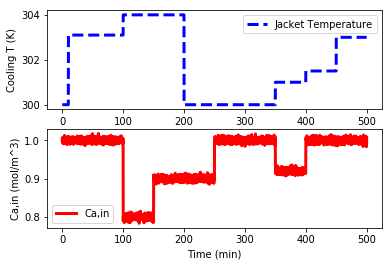

In [8]:
# Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,Tc,'b--',lw=3)
plt.ylabel('Cooling T (K)')
plt.legend(['Jacket Temperature'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,Cin,'r-',lw=3)
plt.ylabel('Ca,in (mol/m^3)')
plt.xlabel('Time (min)')
plt.legend(['Ca,in'],loc='best')


plt.show()

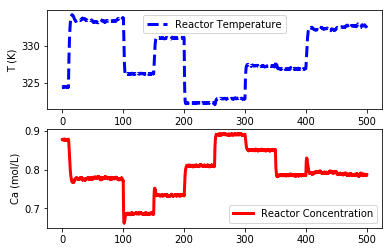

In [9]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(t,T,'b--',lw=3)
plt.ylabel('T (K)')
plt.xlabel('Time (min)')
plt.legend(['Reactor Temperature'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,Ca,'r-',lw=3)
plt.ylabel('Ca (mol/L)')
plt.legend(['Reactor Concentration'],loc='best')

plt.show()

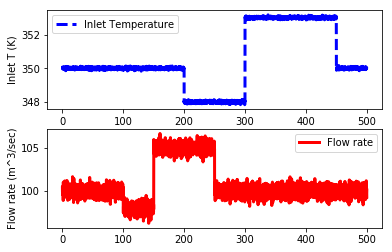

In [10]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,Tin,'b--',lw=3)
plt.ylabel('Inlet T (K)')
plt.xlabel('Time (min)')
plt.legend(['Inlet Temperature'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,Q,'r-',lw=3)
plt.ylabel('Flow rate (m^3/sec)')
plt.legend(['Flow rate'],loc='best')
plt.show()

In [11]:
df = pd.DataFrame()

df["time"] = t
df["coolingTemp"] = Tc
df["concentrationA_inlet"] = Cin
df["Temp_inlet"] = Tin
df["flowRate"] = Q
df["concentrationA"] = Ca
df["Temp"] = T

In [12]:
df

,time,coolingTemp,concentrationA_inlet,Temp_inlet,flowRate,concentrationA,Temp
0,0.0,300.0,1.005721,349.971585,100.378117,0.877253,324.475443
1,0.1,300.0,0.996156,349.984979,99.911718,0.876882,324.471327
2,0.2,300.0,1.000786,350.030465,100.384014,0.877039,324.483159
3,0.3,300.0,1.002189,349.959085,99.624769,0.877224,324.469100
4,0.4,300.0,1.001222,350.020165,99.845943,0.877331,324.467922
...,...,...,...,...,...,...,...
4996,499.6,303.0,0.983177,350.029926,100.045980,0.784940,332.451487
4997,499.7,303.0,1.001176,350.009031,99.925008,0.785548,332.433950
4998,499.8,303.0,0.995901,349.990175,100.280401,0.785682,332.422273
4999,499.9,303.0,0.991654,350.008787,100.036713,0.785373,332.407159


In [13]:
df.to_csv("cstr_leaf_synethic_example.csv", index=False)

## Reference

http://apmonitor.com/do/index.php/Main/NonlinearControl

https://apmonitor.com/pdc/index.php/Main/StirredReactor
    